In [ ]:
# OBJETIVO:
# Treinar o modelo Doc2Vec e aferir a qualidade de suas representações vetoriais.
# (requer o notebook _6_metrica sob a mesma pasta deste)

In [ ]:
#!pip3 install gensim
#!pip3 install ipynb
import gensim
import matplotlib.pyplot as plt
import multiprocessing
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from importlib.metadata import version
from ipynb.fs.defs._6_metrica import calc_idcg, calc_ndcg, calc_ranking_metrics, calc_cluster_metrics
from nltk.tokenize import RegexpTokenizer
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# REQUER gensim 4.0.1+
version('gensim')

'4.0.1'

In [3]:
# carrega os datasets "treino" e "teste" criados no notebook _7_treino_teste
treino = pd.read_csv('datasets/treino.csv')
teste = pd.read_csv('datasets/teste.csv')
treino.info()
teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35863 entries, 0 to 35862
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Acordao         35863 non-null  object
 1   SumulaDerivada  35863 non-null  int64 
 2   Documento       35863 non-null  object
dtypes: int64(1), object(2)
memory usage: 840.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Acordao         102 non-null    object
 1   SumulaDerivada  102 non-null    int64 
 2   Documento       102 non-null    object
dtypes: int64(1), object(2)
memory usage: 2.5+ KB


In [4]:
# o artigo que propôs o algoritmo Paragraph Vector ("Distributed Representations of Sentences and Documents")
# nada menciona a respeito da remoção de stopwords, stemming ou lematização, de modo que não é um requisito,
# podendo ou não beneficiar o resultado.
# o tutorial https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html sugere um pré-processamento
# com a função gensim.utils.simple_preprocess() - contudo, verificou-se que remove todos os dígitos, p. ex.,
# "lei_8112" e "lei_9363" são ambos reduzidos a "lei_", o que parece não ser interessante nesta aplicação.
# optou-se então por utilizar o mesmo tokenizador aplicado ao algoritmo TF-IDF

# tokenizer que considera palavras com 3 ou mais alfanuméricos, ignorando as
# iniciadas por dígito ou '_'
tokenizer_3_alfanum = RegexpTokenizer(r'(?u)\b[^\W\d_]\w{2,}\b')

# função para realizar o pré-processamento dos documentos em formato apropriado para
# o treinamento do modelo (tokens_only=False) ou para a inferência (tokens_only=True)
def preprocess(documents, tokens_only=False):
    for i, document in enumerate(documents):
        tokens = tokenizer_3_alfanum.tokenize(document.lower())
        if tokens_only:
            yield tokens
        else:
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])
            
# tokeniza a coluna 'Documento' do conjunto de treinamento
train_docs = treino['Documento']
tagged_docs = list(preprocess(train_docs))

In [119]:
%%time
# treina o modelo Doc2Vec
cores = multiprocessing.cpu_count()
model = Doc2Vec(tagged_docs, dm=0, vector_size=200, min_count=2, window=3,
                negative=5, hs=0, workers=cores, epochs=50)
print('Vocabulário:', len(model.wv.index_to_key))

Vocabulário: 74486
Wall time: 20min 12s


In [6]:
# testa o modelo utilizando a coluna 'Documento' do conjunto de teste
test_docs = teste['Documento']
test_tokens = list(preprocess(test_docs, True))

In [162]:
# obtém as representações vetoriais para os documentos de teste
test_embeddings = []
for tokens in test_tokens:
    embedding = model.infer_vector(tokens, alpha=0.001, min_alpha=0.0001, steps=50, epochs=200)
    test_embeddings.append(embedding)
test_embeddings = np.vstack(test_embeddings)
# calcula sua matriz de similaridade
similarity = cosine_similarity(test_embeddings, dense_output=True)
print('Matriz de similaridade:', similarity.shape)
# obtém a lista de rótulos de cada documento
labels_true = teste['SumulaDerivada'].tolist()
# calcula o CG e nDCG médios para as 3 e 10 primeiras recomendações
mean_cg, mean_ndcg = calc_ranking_metrics(similarity, labels_true, 3)
print('CG(3) médio: %0.3f' % mean_cg)
print('nDCG(3) médio: %0.3f' % mean_ndcg)
mean_cg, mean_ndcg = calc_ranking_metrics(similarity, labels_true, 10)
print('CG(10) médio: %0.3f' % mean_cg)
print('nDCG(10) médio: %0.3f' % mean_ndcg)
# calcula indicadores para o desempenho da clusterização da matriz de similaridade
labels_pred = calc_metrics(similarity, labels_true)

Matriz de similaridade: (102, 102)
CG(3) médio: 2.245
nDCG(3) médio: 0.764
CG(10) médio: 4.176
nDCG(10) médio: 0.798
Clusters: 17
Clustering (ground-truth):
[ 96  96  96  96  96  96  99  99  99  99  99  99 113 113 113 113 113 113
 114 114 114 114 114 114 120 120 120 120 120 120 125 125 125 125 125 125
 127 127 127 127 127 127 130 130 130 130 130 130 132 132 132 132 132 132
 137 137 137 137 137 137 140 140 140 140 140 140 141 141 141 141 141 141
 145 145 145 145 145 145 148 148 148 148 148 148 151 151 151 151 151 151
 154 154 154 154 154 154 158 158 158 158 158 158]
Clustering (predicted):
[ 4  4 16  4  4  4 10 11 16  6 10 10  0 11 14 14 14  6  1  1  1  1  4  1
  9  9  9  9  9  9 11 11 11 11 14 11  2  2  2  2  2  2  1  1  1  4  1  1
 13 13 13 13 13 13  7  7  7  7  7  7 14 12 12 12 12 12 15 15 15 15 15 15
  5  5  5  5  5  5 16 10 16 16  6  6  3  3  3  3  3  3  8  8  8  8  8  8
  2  2  2  2  2  2]
Homogeneity: 0.854
Completeness: 0.877
V-measure: 0.865
Adjusted Rand Index (ARI): 0.686
Adj

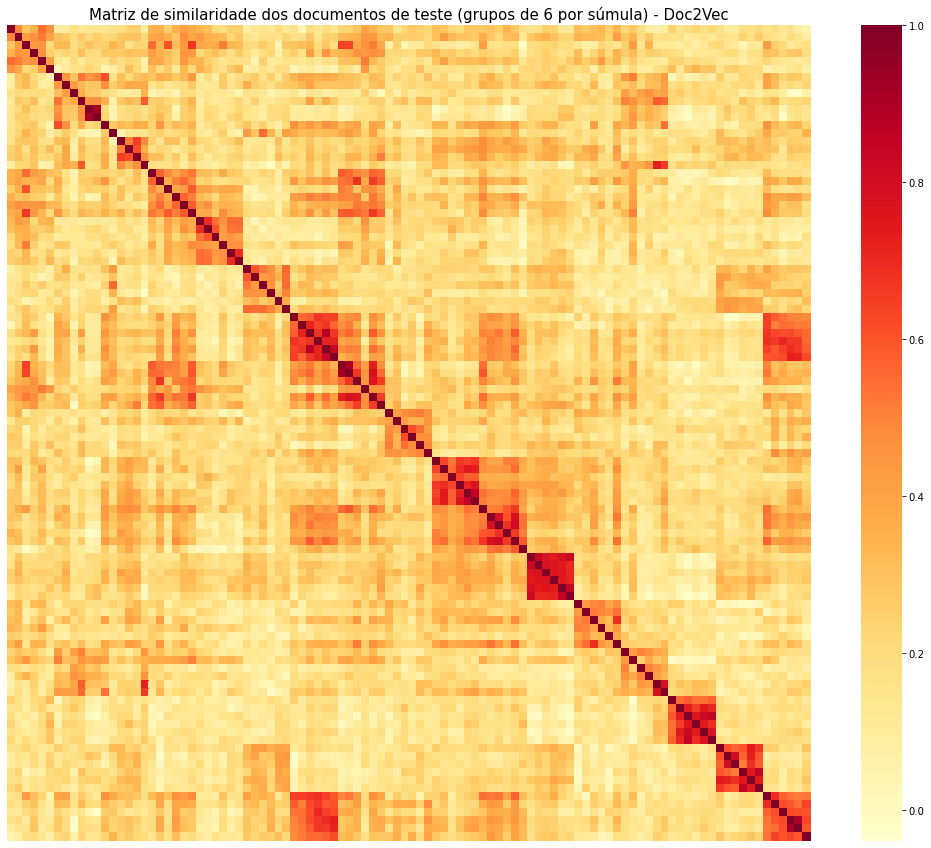

In [163]:
# mapa de calor da matriz de similaridade dos precedentes do conjunto de teste
# os precedentes aparecem em grupos de tamanho homogêneo, para cada súmula derivada
precs_por_sumula = sum(1 for label in labels_true if label == labels_true[0])
fig, ax = plt.subplots(figsize=(18, 15))
g = sns.heatmap(similarity, xticklabels=False, yticklabels=False, cmap='YlOrRd', ax=ax)
g.set_title(f'Matriz de similaridade dos documentos de teste (grupos de {precs_por_sumula}'\
            ' por súmula) - Doc2Vec', fontsize=15)
plt.show()

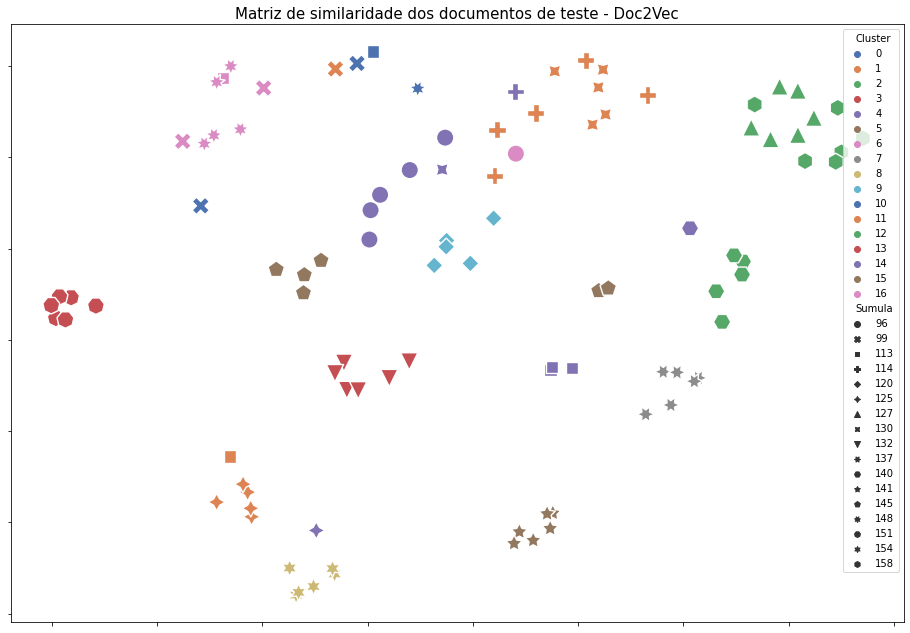

In [165]:
# gráfico de dispersão da matriz de similaridade (reduzida por t-SNE)
tSNE = TSNE(n_components=2, init='pca', random_state=9)
similarity_2d = tSNE.fit_transform(similarity)
x = similarity_2d[:,0]
y = similarity_2d[:,1]
df = pd.DataFrame()
df['Sumula'] = labels_true
df['Cluster'] = labels_pred
df['x'] = x
df['y'] = y
fig, ax = plt.subplots(figsize=(16, 11))
g = sns.scatterplot(data=df, x='x', y='y', hue='Cluster', palette='deep',
                    style='Sumula', legend='full', s=300)
g.set_title('Matriz de similaridade dos documentos de teste - Doc2Vec', fontsize=15)
g.set(xticklabels=[], xlabel=None, yticklabels=[], ylabel=None)
plt.show()

In [166]:
# busca, no conjunto de teste, 10 documentos similares ao primeiro e calcula o nDCG
# utiliza aqui a matriz de similaridade do conjunto de teste
n = similarity.shape[0]
p = 10
# primeiro documento
i = 0
print('Query:', teste.iloc[i]['Acordao'])
# rotulo de doc[i]
label = labels_true[i]
# número de documentos com mesmo rótulo de doc[i]
num_same_label = 0
# lista de tuplas de similaridade entre doc[i] e doc[j], rótulo de doc[j] e índice j
tuples = []
for j in range(0, n):
    # ignora o próprio
    if i == j:
        continue
    if labels_true[j] == label:
        num_same_label += 1
    tuples.append((similarity[i, j], labels_true[j], j))
# calcula o idcg
idcg = calc_idcg(num_same_label, p)
# ordena em ordem decrescente de similaridade
ranking = sorted(tuples, reverse=True, key=lambda t:t[0])
# fica apenas com os p primeiros
ranking = ranking[0:p]
# calcula as relevâncias binárias
relevance = [1 if t[1] == label else 0 for t in ranking]
# calcula o ndcg
ndcg = calc_ndcg(np.array(relevance), idcg, p)
# exibe o nDCG e a lista de recomendações
print('nDCG: %0.3f' % ndcg)
teste.iloc[[t[2] for t in ranking]].reset_index(drop=True)

Query: 1202-000.990
nDCG: 0.825


,Acordao,SumulaDerivada,Documento
0,1402-001.416,96,Assunto: Processo Administrativo Fiscal\nAno-c...
1,1301-001.202,96,Assunto: Imposto sobre a Renda de Pessoa Juríd...
2,9101-001.468,96,Assunto: Imposto sobre a Renda de Pessoa Juríd...
3,2202-002.804,114,Assunto: Imposto sobre a Renda Retido na Fonte...
4,1401-002.049,130,Assunto: Processo Administrativo Fiscal\nAno-c...
5,2301-004.531,114,Assunto: Imposto sobre a Renda Retido na Fonte...
6,1301-001.544,114,Assunto: Imposto sobre a Renda de Pessoa Juríd...
7,2202-002.561,114,Assunto: Imposto sobre a Renda Retido na Fonte...
8,1302-000.993,96,Assunto: Imposto sobre a Renda de Pessoa Juríd...
9,1103-000.904,114,Assunto: Imposto sobre a Renda de Pessoa Juríd...
